# Trabajo Práctico 1

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import itertools
import pandas as pd

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

## 1. Entrene una red de Hopfield ‘82 con un conjunto de imágenes binarias.

Se encuentran 2 tamaños distintos en las imágenes de prueba, por lo que se las subdivide en 2 grupos:
* De tamaño 45x50
* De tamaño 50x60

In [3]:
ImageNames45x60=[
  "images/paloma.bmp",
  "images/quijote.bmp",
  "images/torero.bmp",
];

ImageNames50x50=[  
  "images/panda.bmp",
  "images/perro.bmp", 
  "images/v.bmp"
]

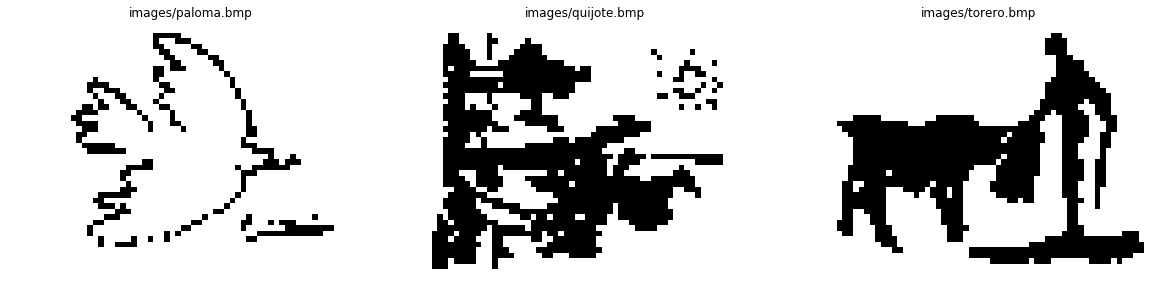

In [4]:
f, subplots = plt.subplots(1, 3)
for path,splt in zip( ImageNames45x60, subplots):
    splt.imshow(plt.imread(path))
    splt.set_title(path)
    splt.axis('off')

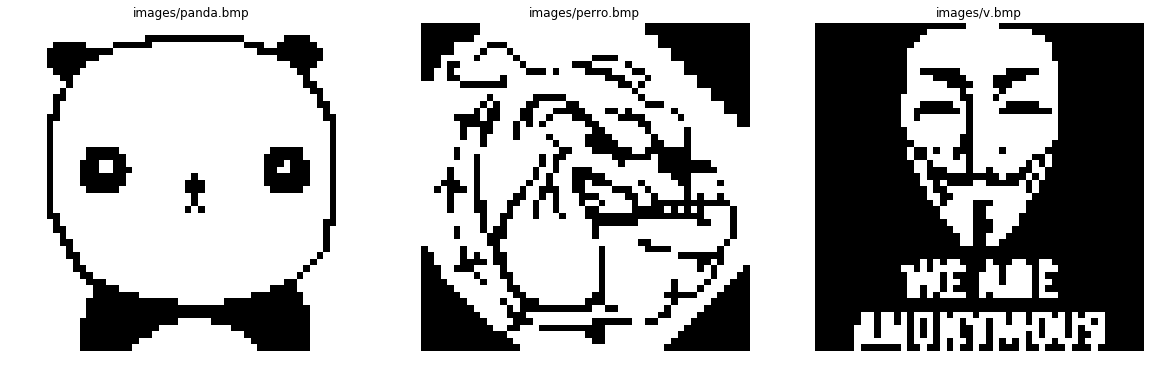

In [5]:
f, subplots = plt.subplots(1, 3)
for path,splt in zip( ImageNames50x50, subplots):
    splt.imshow(plt.imread(path))
    splt.set_title(path)
    splt.axis('off')

In [6]:
# Definición de funciones auxiliares:

In [7]:
def signo(val):
  return (val >= 0)*2-1

In [8]:
def hopfield(seed,w,N,M):
    outVal = np.copy(seed);
    iteration = 1;
    changed = True;
    while(changed):
        changed = False;
        for i in np.random.permutation(len(outVal)):
            hi=signo(w[i,:].reshape(1,-1).dot(outVal))
            changed |= (hi != outVal[i])
            outVal[i]=hi
    #PlotImage(plt.gca(),outVal.reshape(N,M))
    return outVal

In [9]:
def LoadImages(image_file_names):
    #Carga de las Imagenes  
    return [ (plt.imread(file_name)[:,:,0] / 255 * 2 -1 ).reshape(-1,1) for file_name in image_file_names]
    #return np.squeeze( [ (plt.imread(file_name)[:,:,0] / 255 * 2 -1 ).reshape(-1,1) for file_name in image_file_names], axis=2 )

In [10]:
def PlotImage(pobj,imgArray):
    pobj.imshow(( imgArray >= 0 ).astype("double"),cmap='gray')
    #pobj.axis('off')
    pobj.xaxis.set_ticks([])
    pobj.yaxis.set_ticks([])
    pobj.spines['top'].set_visible(False)
    pobj.spines['right'].set_visible(False)
    pobj.spines['bottom'].set_visible(False)
    pobj.spines['left'].set_visible(False)

In [11]:
def CalculateWeights(Images):
    return np.sum( [ img.dot(img.transpose())-np.eye(len(img)) for img in Images ] , 0 )

In [12]:
def AutoTest(SourceImages, TargetImages, W,N,M):
    #chequeo si aprendio evaluando las mismas imagenes.
    return [ np.all(hopfield(src,W,N,M) == tgt) for src,tgt in zip(SourceImages, TargetImages)]

### a) Verifique si la red aprendió las imágenes enseñadas.

In [13]:
def DoesLearn(ImageNames,h,w):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    Learned=AutoTest(Images,Images,W,h,w)
    #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip(ImageNames, Learned)],columns=["Image","Learned"]).set_index(["Image",])

In [14]:
DoesLearn(ImageNames45x60,45,60)

,Learned
Image,
images/paloma.bmp,True
images/quijote.bmp,True
images/torero.bmp,True


In [15]:
DoesLearn(ImageNames50x50,50,50)

,Learned
Image,
images/panda.bmp,True
images/perro.bmp,True
images/v.bmp,True


Se verifica que se aprendieron ambos grupos de 3 imágenes.

### b) Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes aprendidas: agregado de ruido, elementos borrados o agregados.

#### Ruido
Se le agrega ruido digital a las imágenes. Invirtiendo cada pixel de la imágen con una probabilidad *p*

In [16]:
def AddNoise(image,level):
    return image * (( np.random.rand(* image.shape) > level ).astype(np.int32) * 2 - 1);

In [17]:
def TestNoise(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
            
    levels=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]    
    #f, subplots = plt.subplots(len(levels), len(ImageNames))
    
    df = pd.DataFrame(columns=["Image"]+levels)
    df["Image"]=ImageNames
    
    #for lvl,pltRow in zip(levels,subplots):
    for lvl in levels:
        ImagesWithNoise = [ AddNoise(image,lvl) for image in Images ]
        f, pltRow = plt.subplots(1, len(ImageNames))
        
        for image,pltobj in zip(ImagesWithNoise,pltRow):
            PlotImage(pltobj,image.reshape(N,M))
        pltRow[0].set_ylabel("p=%.2g" % lvl)
        
        
        df[lvl] = AutoTest(ImagesWithNoise,Images,W,N,M)
        
    
    return df.set_index(["Image",])

,0.01,0.05,0.1,0.2,0.3,0.4,0.5
Image,,,,,,,
images/paloma.bmp,True,True,True,True,True,True,False
images/quijote.bmp,True,True,True,True,True,True,False
images/torero.bmp,True,True,True,True,True,True,False


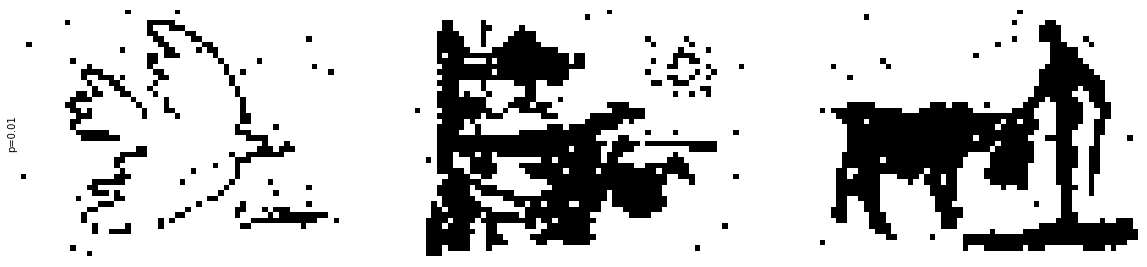

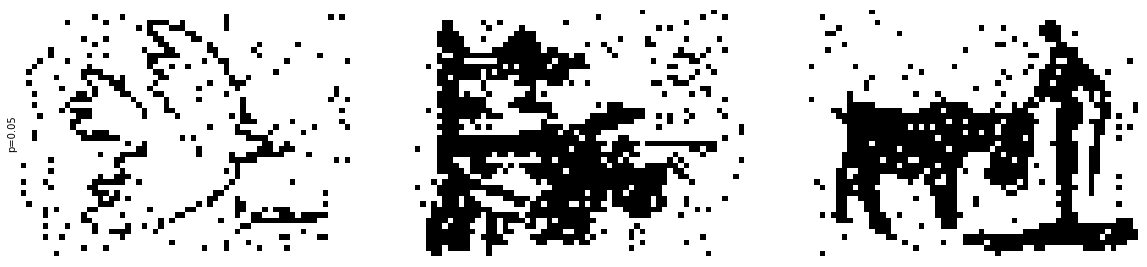

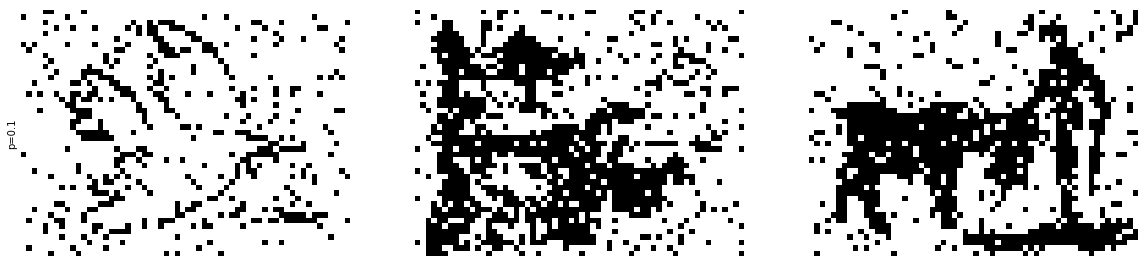

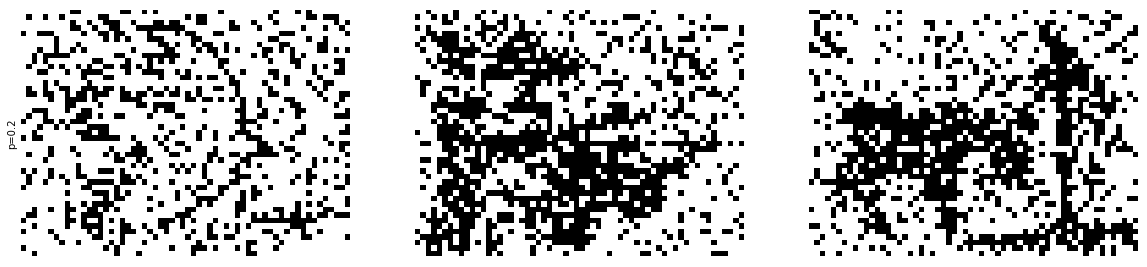

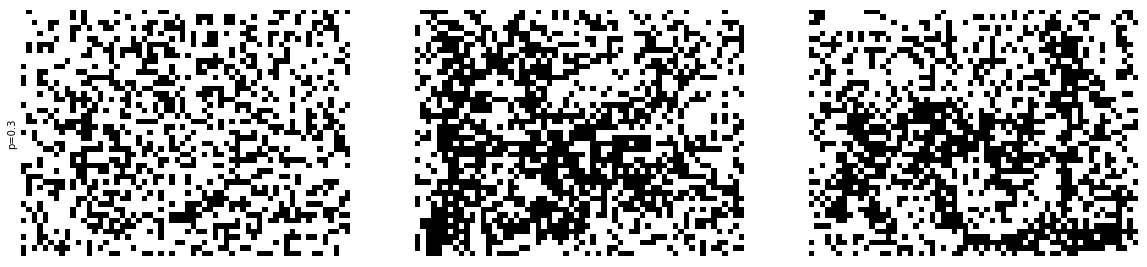

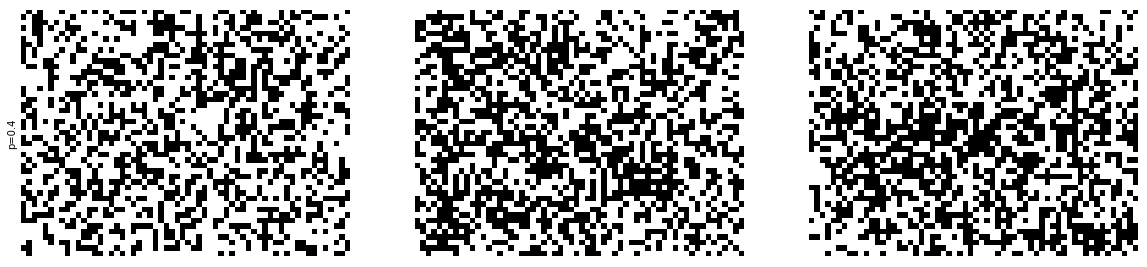

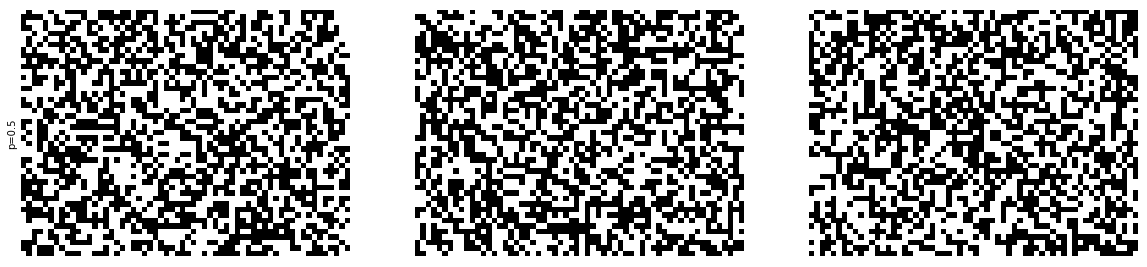

In [18]:
TestNoise(ImageNames45x60,45,60)

,0.01,0.05,0.1,0.2,0.3,0.4,0.5
Image,,,,,,,
images/panda.bmp,True,True,True,True,True,True,False
images/perro.bmp,True,True,True,True,True,True,False
images/v.bmp,True,True,True,True,True,True,True


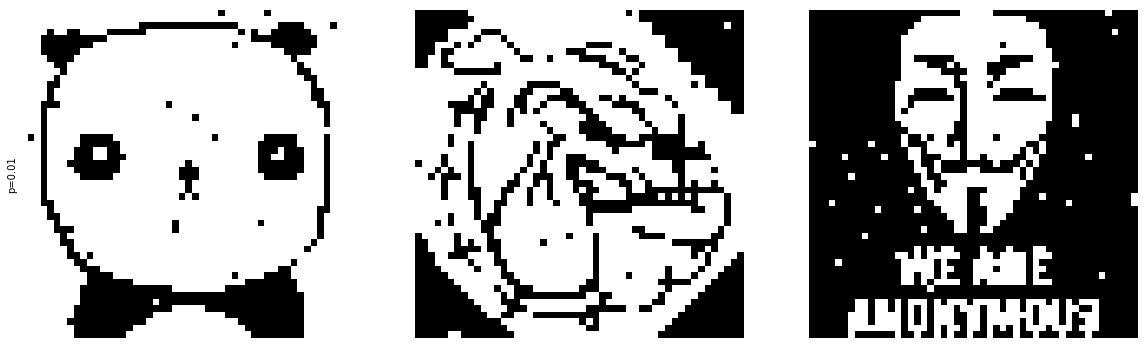

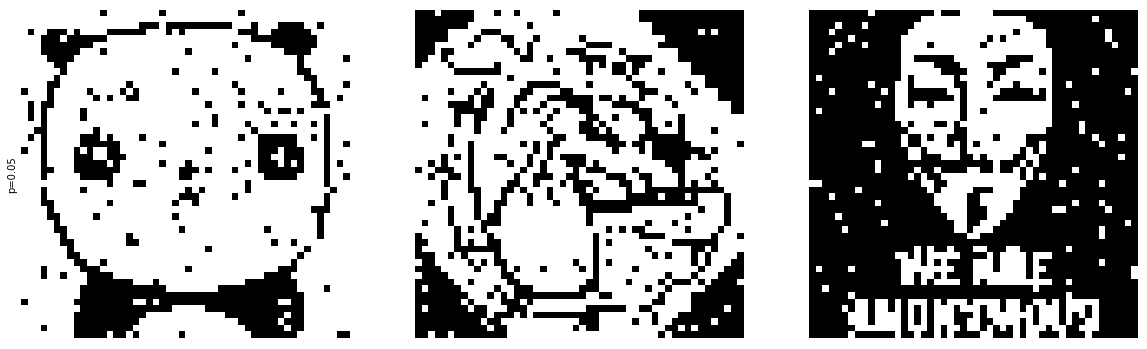

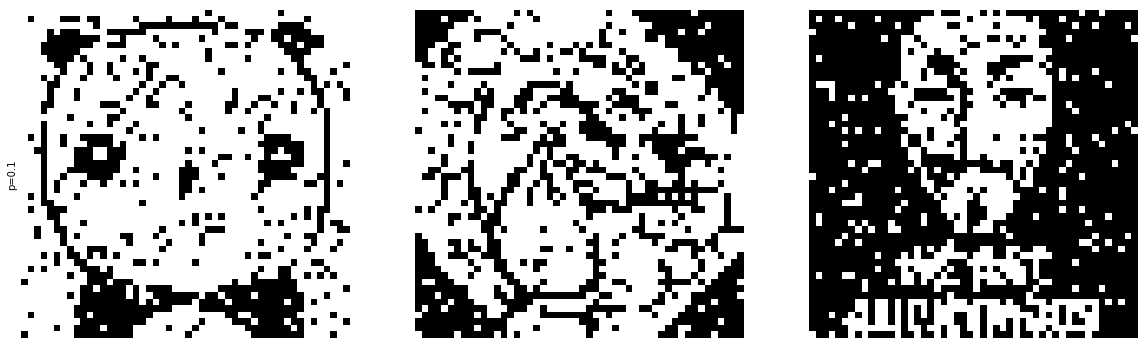

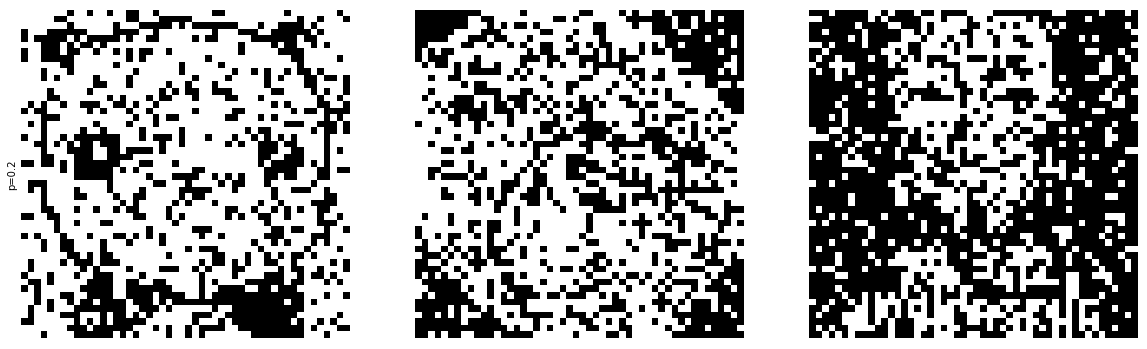

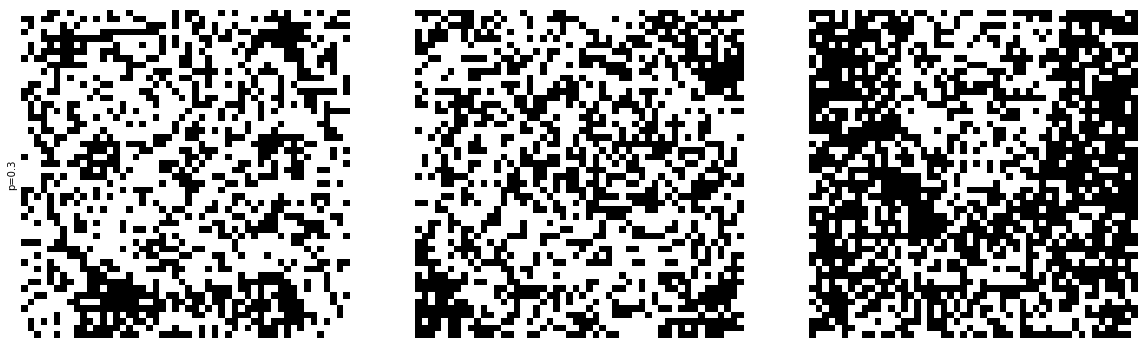

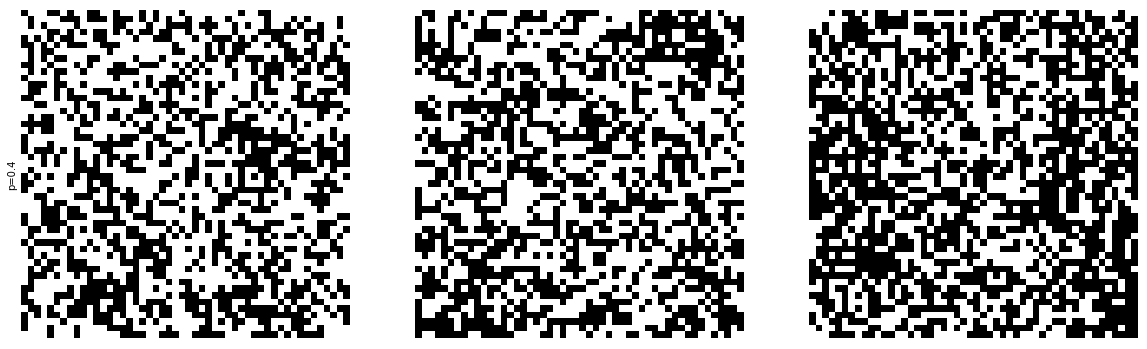

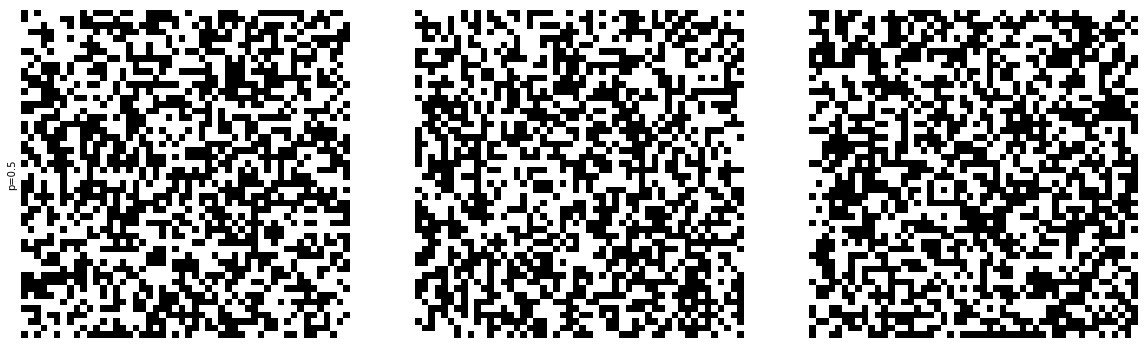

In [19]:
TestNoise(ImageNames50x50,50,50)

Repetidos ensayos mostraron que para 3 imágenes el algoritmo es robusto a ruido digital hasta p=0.4. Con p=0.5 el algoritmo converje a la imagen equivocada más frecuentemente de lo que acierta. Para p > 0.5 el atractor cambia a la imágen inversa.

#### Máscaras

Se ensayaron máscaras rectangulares que cubren distintos porcentajes de las imágenes de prueba, y se las usó como entrada en el algoritmpo de Hopfield.

In [20]:
def CreateMask(N,M,lvl):
    mask=np.zeros([N,M])
    mask[0:int(np.floor(N*lvl)),0:int(np.floor(M*lvl))]=1
    return mask

In [21]:
def MaskImages(Images,N,M,lvl):
    mask=CreateMask(N,M,lvl).reshape(-1,1)
    return [ ((image + mask) >= 0 ).astype(np.int32) * 2 - 1 for image in Images  ]

In [22]:
def TestMasked(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    levels = np.arange(0.2,0.8,0.2)
    
    df = pd.DataFrame(columns=["Image"]+list(levels))
    df["Image"]=ImageNames
    
    for lvl in levels:
        MaskedImages = MaskImages(Images,N,M,lvl)
        
        f, pltRow = plt.subplots(1, len(ImageNames))
        for image,pltobj in zip(MaskedImages,pltRow):
            PlotImage(pltobj,image.reshape(N,M))
        pltRow[0].set_ylabel("masked=%.2g" % lvl)
        
        df[lvl] = AutoTest(MaskedImages,Images,W,N,M)
        
    return df.set_index(["Image",])

,0.2,0.4,0.6,0.8
Image,,,,
images/paloma.bmp,True,True,True,True
images/quijote.bmp,True,True,False,False
images/torero.bmp,True,True,True,False


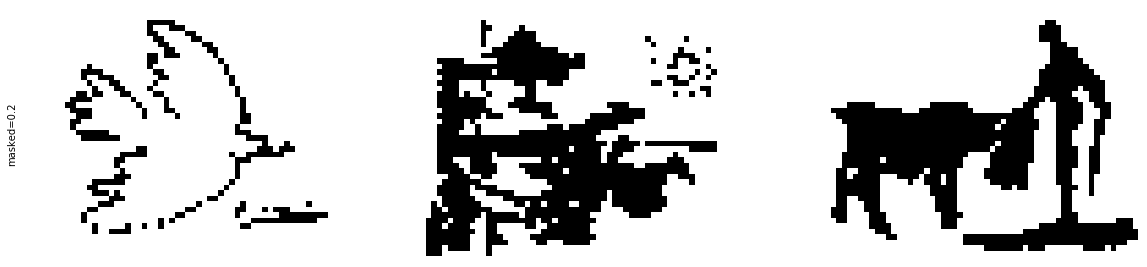

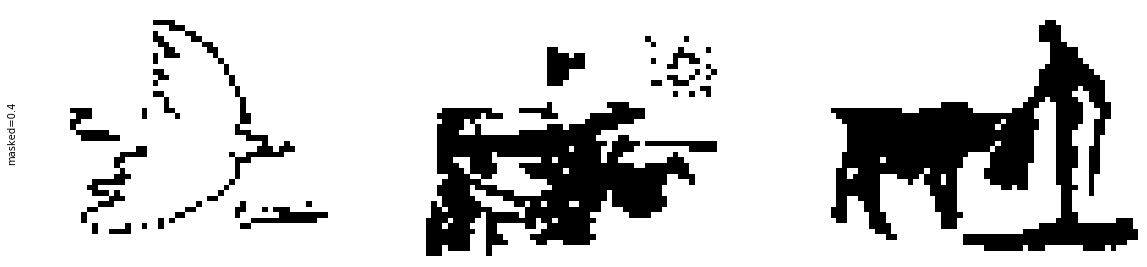

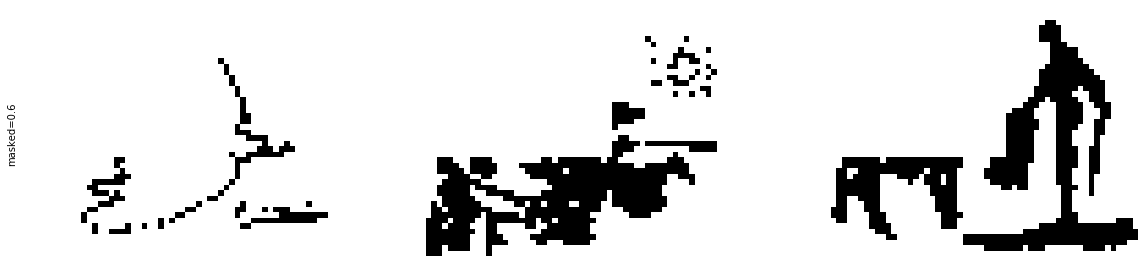

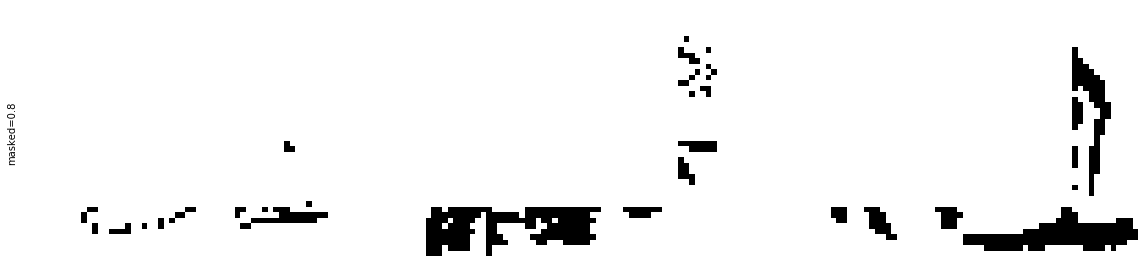

In [23]:
TestMasked(ImageNames45x60,45,60)

,0.2,0.4,0.6,0.8
Image,,,,
images/panda.bmp,True,True,True,True
images/perro.bmp,True,True,True,True
images/v.bmp,True,True,True,False


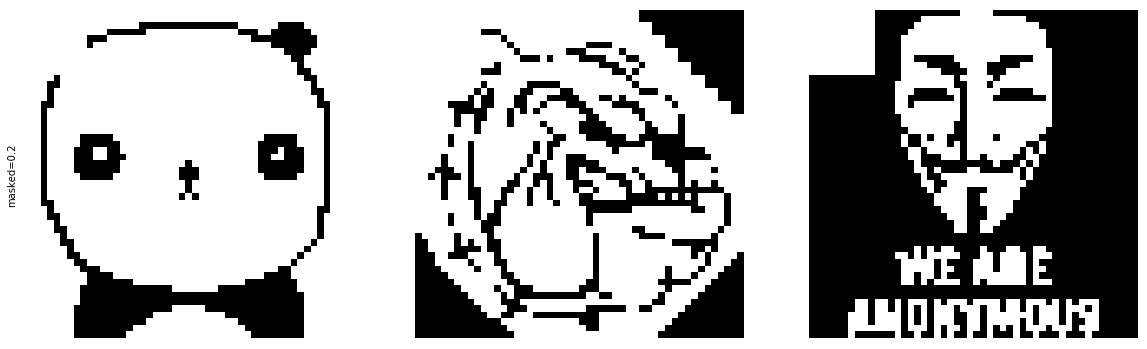

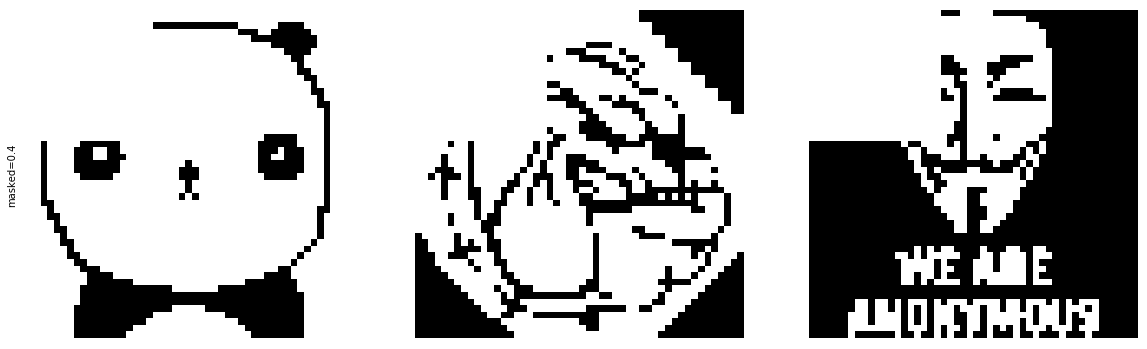

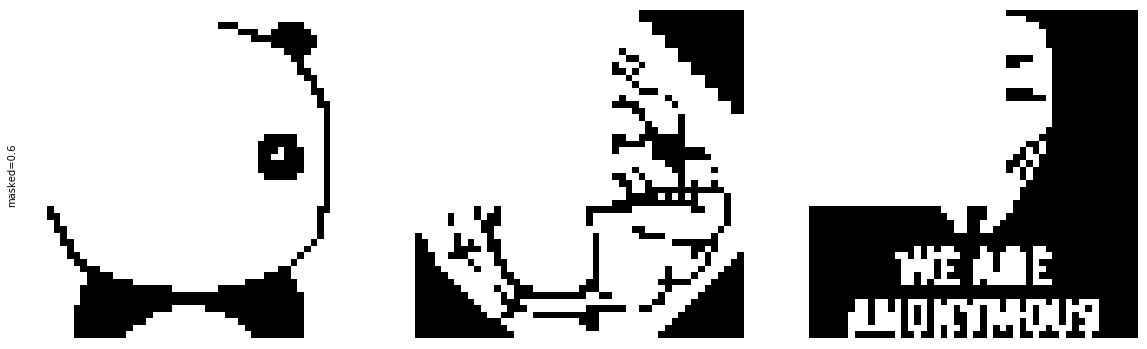

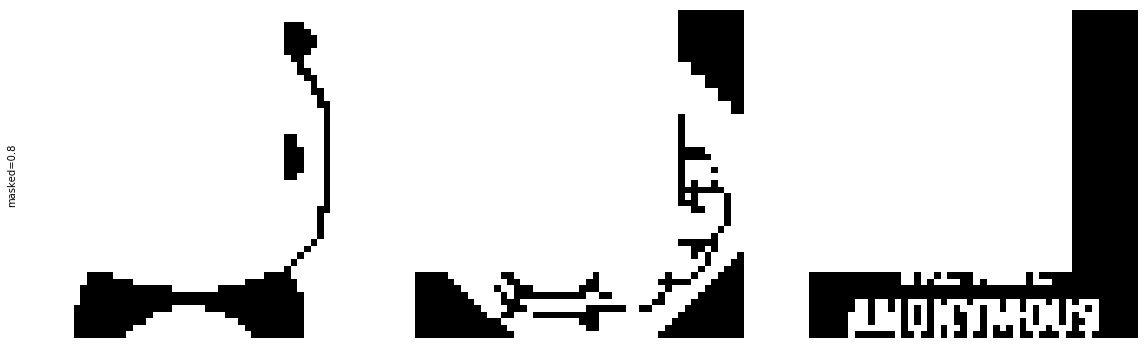

In [24]:
TestMasked(ImageNames50x50,50,50)

Se observa que el algoritmo tolera máscaras que cubren hasta el 60% de la imágen, pero cuando cubre el 80% algunas imágenes comienzan a fallar.

### c) Evalúe la existencia de estados espurios en la red: patrones inversos y combinaciones de un número impar de patrones. *(Ver Spurious States, en la sección 2.2, Hertz, Krogh & Palmer, pág. 24)*.

Validación de los poatrones negativos:

In [25]:
def DoesLearnNegative(ImageNames,h,w):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    negatives=[ -1*image for image in Images]
    
    f, pltRow = plt.subplots(1, len(ImageNames))
    for image,pltobj in zip(negatives,pltRow):
        PlotImage(pltobj,image.reshape(h,w))
        
    Learned=AutoTest(negatives ,negatives,W,h,w)
    #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip(ImageNames, Learned)],columns=["Image","Learned"]).set_index(["Image",])

,Learned
Image,
images/paloma.bmp,True
images/quijote.bmp,True
images/torero.bmp,True


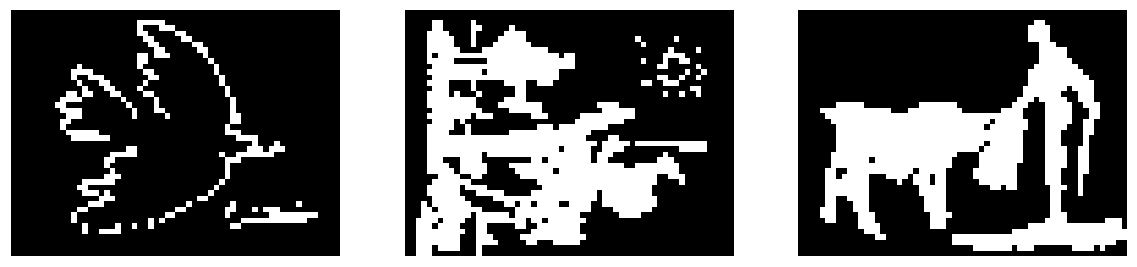

In [26]:
DoesLearnNegative(ImageNames45x60,45,60)

,Learned
Image,
images/panda.bmp,True
images/perro.bmp,True
images/v.bmp,True


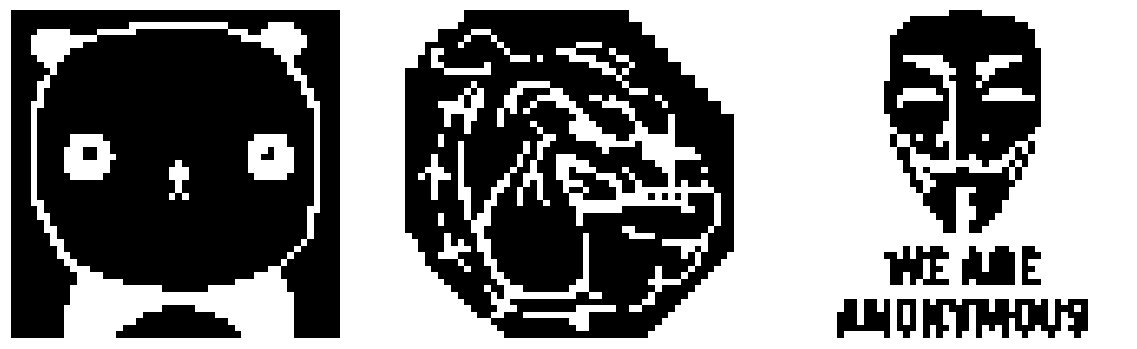

In [27]:
DoesLearnNegative(ImageNames50x50,50,50)

Los patrones negativos fueron aprendidios correctamente. Validado esto, se arma un conjunto de patrones expandido con los patrones positivos y negativos y se evaluan todas las combianaciones suma de 3 elementos de este conjunto.

Esto volverá a evaluar los patrones positivos y negativos, ya que si se suman 3 patrones A + B + C, donde A = -B, A y B se cancelan y queda el patrón C.

In [28]:
def PlotImages(Images,N,M, columns):
    i = 0
    for Image in Images:
        if i == 0:
            f, pltRow = plt.subplots(1, columns)
        PlotImage(pltRow[i],Image.reshape(N,M))
        i+=1
        if i == columns:
            i=0
        
    while ( i > 0 and columns > i ):
        f.delaxes(pltRow[i])
        i+=1

In [29]:
def GenerateOddSpurious(Images):
    ExtendedImages = np.squeeze( Images + [-1 * image for image in Images], axis=2)
    combs = list(itertools.combinations(range(len(ExtendedImages)),3))
    return [ (ExtendedImages[list(comb)].sum(axis=0) >= 0).astype(np.int32) * 2 - 1 for comb in combs ]
    

In [30]:
def TestSpurious(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    SpuriousImages=GenerateOddSpurious(Images)
    
    Learned=AutoTest(SpuriousImages ,SpuriousImages,W,N,M)
    PlotImages( np.unique(SpuriousImages,axis=0), N,M, 4 )
    
    combs = ["".join(comb) for comb in itertools.combinations(["A","B","C","-A","-B","-C"],3)]
        #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip(combs, Learned)],columns=["Comb","Learned"]).set_index(["Comb",]).transpose()

Comb,ABC,AB-A,AB-B,AB-C,AC-A,AC-B,AC-C,A-A-B,A-A-C,A-B-C,BC-A,BC-B,BC-C,B-A-B,B-A-C,B-B-C,C-A-B,C-A-C,C-B-C,-A-B-C
Learned,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


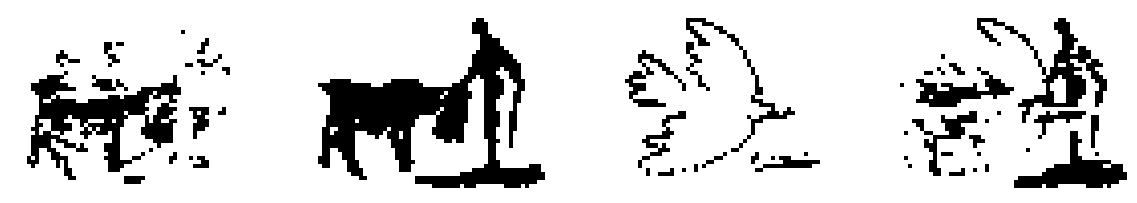

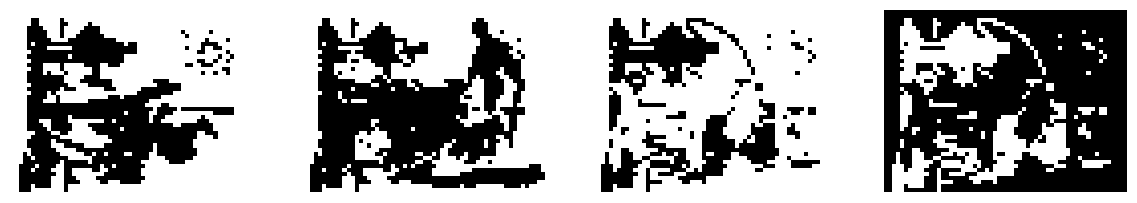

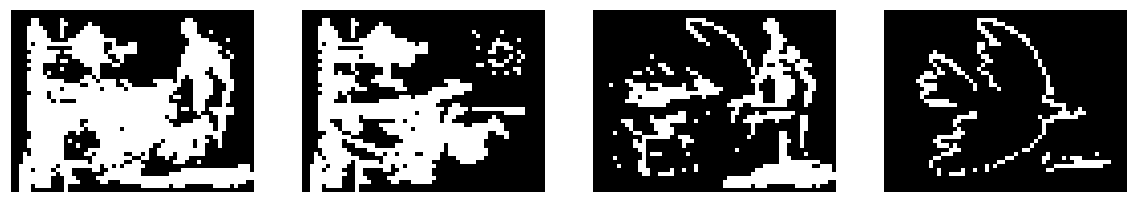

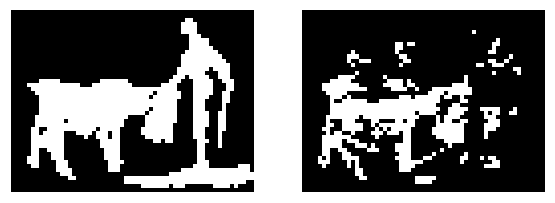

In [31]:
TestSpurious(ImageNames45x60,45,60)

Comb,ABC,AB-A,AB-B,AB-C,AC-A,AC-B,AC-C,A-A-B,A-A-C,A-B-C,BC-A,BC-B,BC-C,B-A-B,B-A-C,B-B-C,C-A-B,C-A-C,C-B-C,-A-B-C
Learned,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


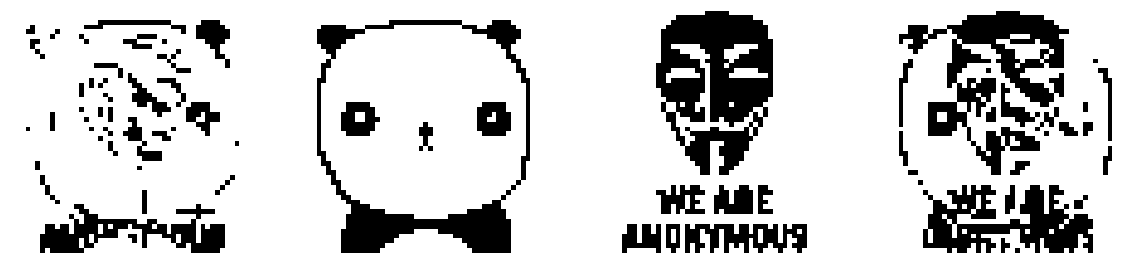

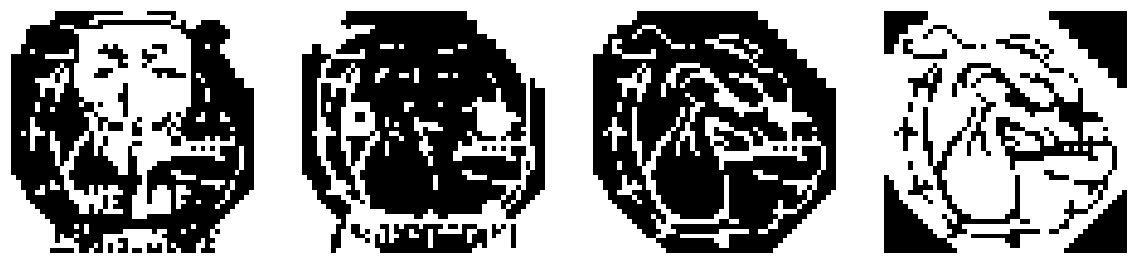

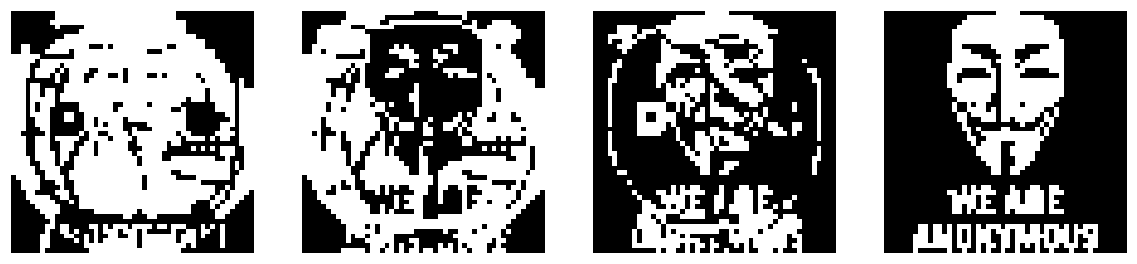

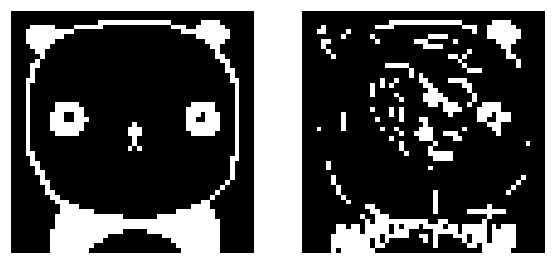

In [32]:
TestSpurious(ImageNames50x50,50,50)

Todos los patrones generados como suma de 3 patrones resulta en un patrón aprendido por la red para ambos conjuntos de imágenes.

### d) Realice un entrenamiento con todas las imágenes disponibles. ¿Es capaz la red de aprender todas las imágenes? Explique.

Para poder cargar todas las imágenes juntas es necesario primero homogeneizar el tamaño. Para ello se eligió extender las imágenes con un padding.o

In [33]:
def LoadImagesWithPadding(ImageFileNames,N,M,paddingFunction):
    for image_name in ImageFileNames:
        base_image=(plt.imread(image_name)[:,:,0] / 255 ).astype(np.double) * 2 - 1
        padded_image=(paddingFunction(N,M) > 0.5).astype(np.int32).astype(np.double) * 2 - 1
        padded_image[:base_image.shape[0],:base_image.shape[1]] = base_image
        yield padded_image.reshape(-1,1)

In [34]:
def DoesLearnWithPadding(ImageNames,h,w,paddingFunction):
    Images=list(LoadImagesWithPadding(ImageNames,h,w,paddingFunction))
    PlotImages(Images,h,w,3)
    W=CalculateWeights(Images)
    Learned=AutoTest(Images,Images,W,h,w)
    #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip(ImageNames, Learned)],columns=["Image","Learned"]).set_index(["Image",])



,Learned
Image,
images/paloma.bmp,False
images/quijote.bmp,True
images/torero.bmp,False
images/panda.bmp,True
images/perro.bmp,True
images/v.bmp,True


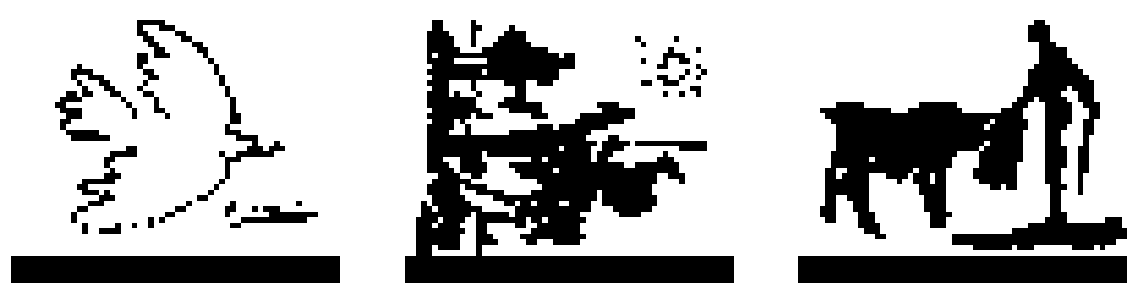

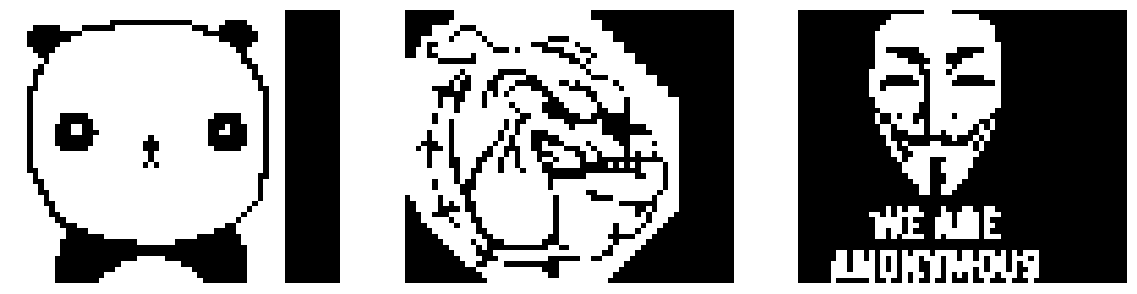

In [35]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.zeros([h,w]))

,Learned
Image,
images/paloma.bmp,False
images/quijote.bmp,False
images/torero.bmp,False
images/panda.bmp,False
images/perro.bmp,False
images/v.bmp,True


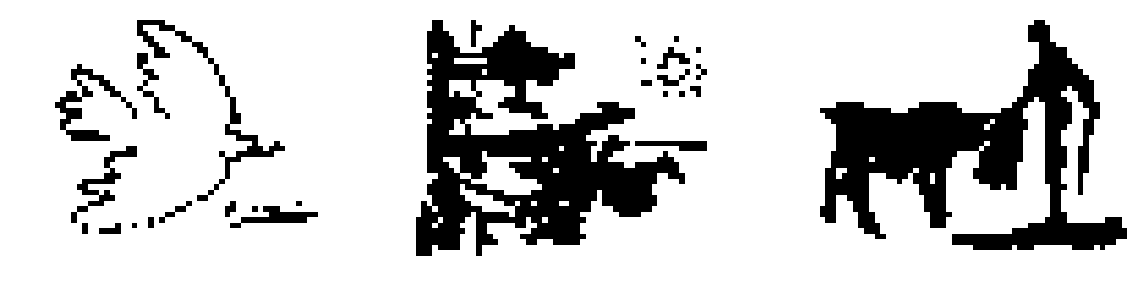

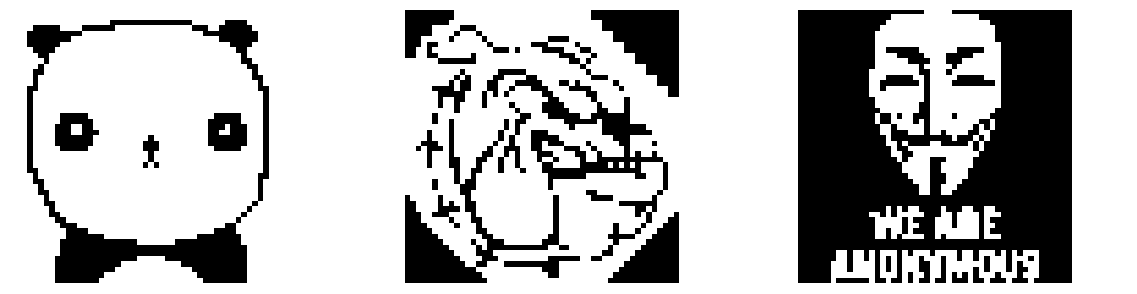

In [36]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.ones([h,w]))

,Learned
Image,
images/paloma.bmp,False
images/quijote.bmp,True
images/torero.bmp,True
images/panda.bmp,True
images/perro.bmp,True
images/v.bmp,True


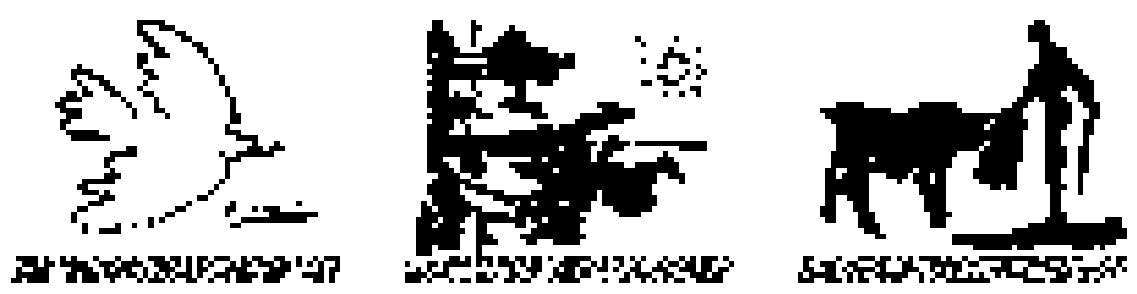

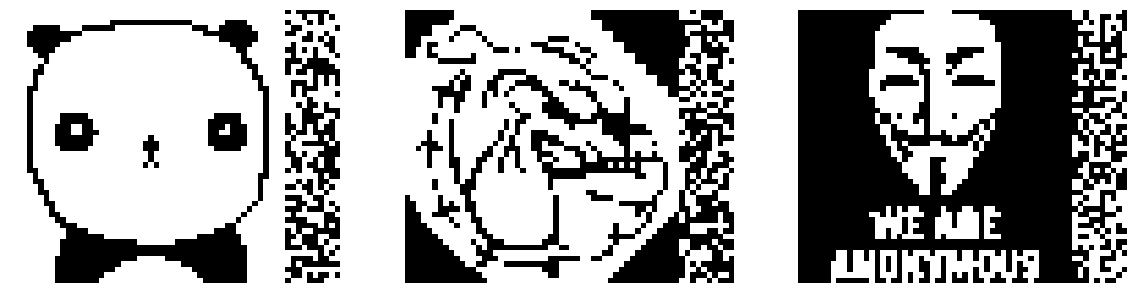

In [52]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,np.random.rand)

En ninguno de los casos la red pudo aprender todos los patrones, pero los resultados variaron con el tipo de padding utilizado.
El padding el blanco fue el que produjo mayores solapamientos y solo aprendio un patrón.
El padding en negro produjo que 2 patrones no pudieran ser aprendidos.
El padding con patrones pseudoaleatorios produje que 1 o 2 patrones nos e pudieran aprender dependiendo de la corrida.

In [55]:
def ConvergingPatterns(ImageNames,h,w,paddingFunction):
    Images=list(LoadImagesWithPadding(ImageNames,h,w,paddingFunction))
    W=CalculateWeights(Images)
    PlotImages([hopfield(image,W,h,w) for image in Images],h,w,3)

Patrones a los que converje el algoritmo:

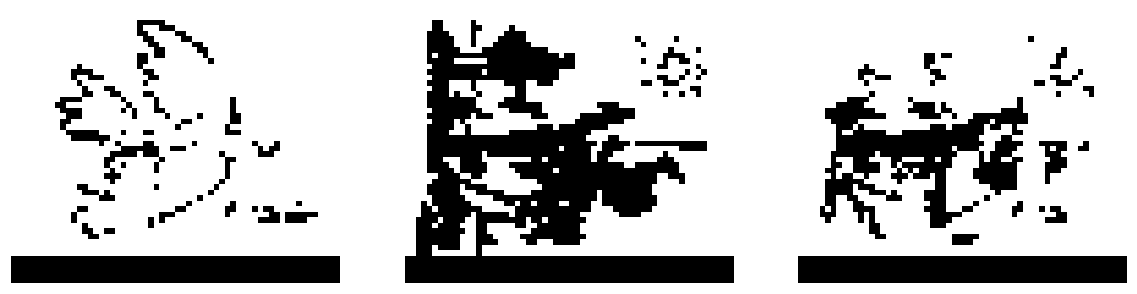

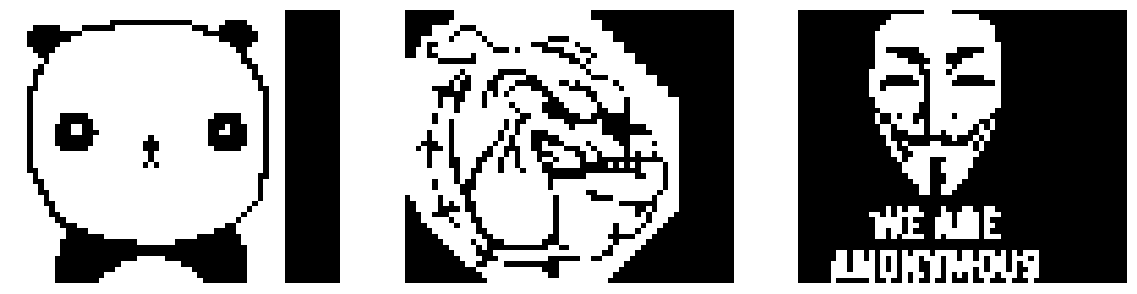

In [174]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.zeros([h,w]))

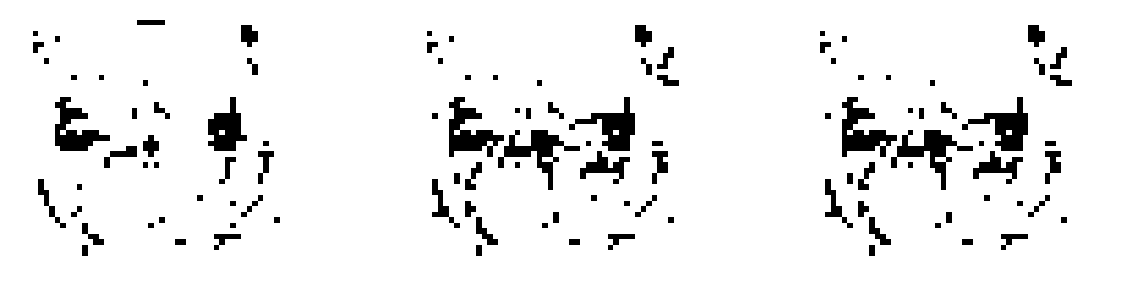

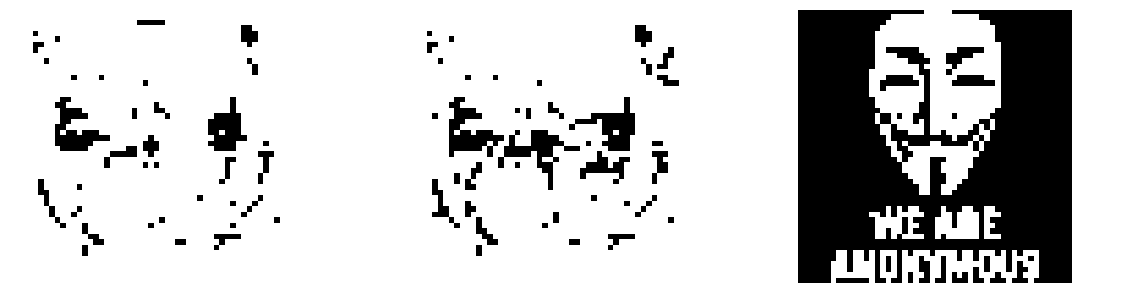

In [175]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.ones([h,w]))

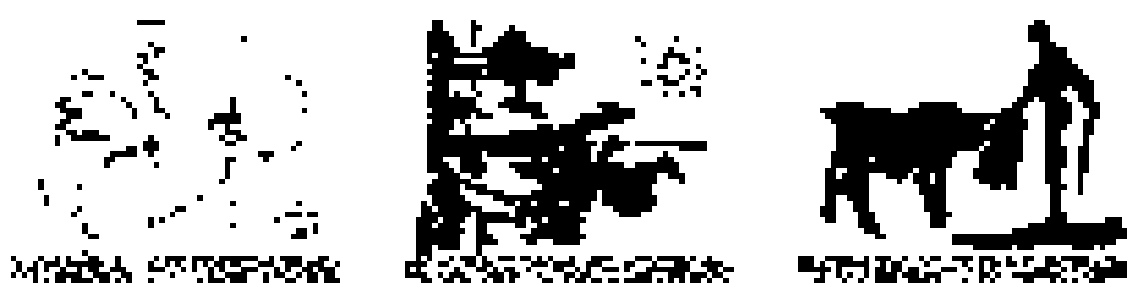

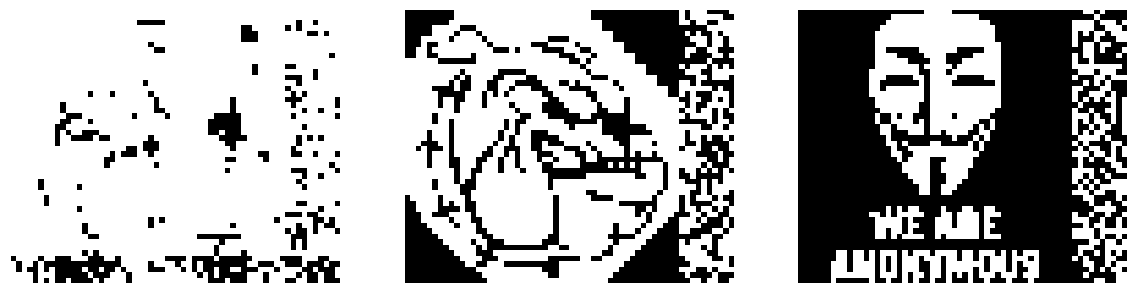

In [176]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,np.random.rand)

Observando a dónde convergen los patrones que fallaron, se observa que los patrones de salida contienen parte de la información del patrón de entrada por ejemplo las alas de la paloma y las patas del toro todavía pueden apreciarse para el caso del padding negro.

Se concluye que los patrones no son lo suficientemente ortogonales entre sí para ser aprendidos todos.

## 2. Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño de la red.

###  a) Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteración con actualización sincrónica).

In [221]:
tableHertzEtAl=pd.DataFrame([
    [0.001, 0.105],
    [0.0035, 0.138],
    [0.01,0.185],
    [0.05,0.37],
    [0.1,0.61]],columns=["Perror","pmax/N"]).set_index("Perror")

In [222]:
def randImageGen(N,P):
    return [ (np.random.rand(N,1) > 0.5).astype(np.int32).astype(np.double) * 2 - 1  for _ in range(P)]

In [223]:
def calcPError(algo,imageGen,N,P):
    Images=imageGen(N,P)
    W=CalculateWeights(Images)
    return np.sum([(algo(image,W,N,1) != image ).astype(np.int32).sum()/N for image in Images ])/P

In [224]:
class ExceededMaxIterations(Exception):
    pass

In [225]:
def repeatPError(algo,imageGen,N,P):
    step=10
    acc=[]
    while(True):
        try:
            #Exception Shuld 
            acc+=[ calcPError(algo,imageGen,N,P) for _ in range(10) ]
        except ExceededMaxIterations as e:
            print(str(e))
            continue
         
        std = np.std(acc,ddof=1)
        if 2.32*std/np.sqrt(len(acc)) < 0.01:
            break
        #else:
        #    print(2.32*std/np.sqrt(len(acc)))
    return np.mean(acc)

In [226]:
def FillTable(algo, imageGen, span ):
    df=pd.DataFrame(columns=["N","P","PError"]).set_index(["N","P"])

    for N in span:
        pError=0
        P=0
        while pError < 0.15:
            P+=1
            pError = repeatPError(algo,randImageGen,N,P)
            df.loc[(N,P),"PError"]=pError
            #print(N,P,pError),
    return df
    

In [231]:
def PlotCapacity(df, tableHertzEtAl):
    for N, new_df in df.groupby(level=0):
        ndf=new_df.reset_index()
        plt.plot(ndf["P"]/ndf["N"],ndf["PError"],label=N)


    ndf=tableHertzEtAl.reset_index()
    plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)
    plt.legend()

Capacidad de la red para Hopfield Asíncrono:

In [228]:
asyncCapacity=FillTable(hopfield, np.arange(10,30,10))
asyncCapacity.transpose()

N        10                                            20                 \
P        1       2         3      4         5     6    1    2         3    
PError  0.0  0.0025  0.003333  0.063  0.096273  0.16  0.0  0.0  0.001667   

N                                                                          
P             4      5         6         7         8         9         10  
PError  0.009063  0.023  0.060486  0.086389  0.134836  0.146579  0.175536

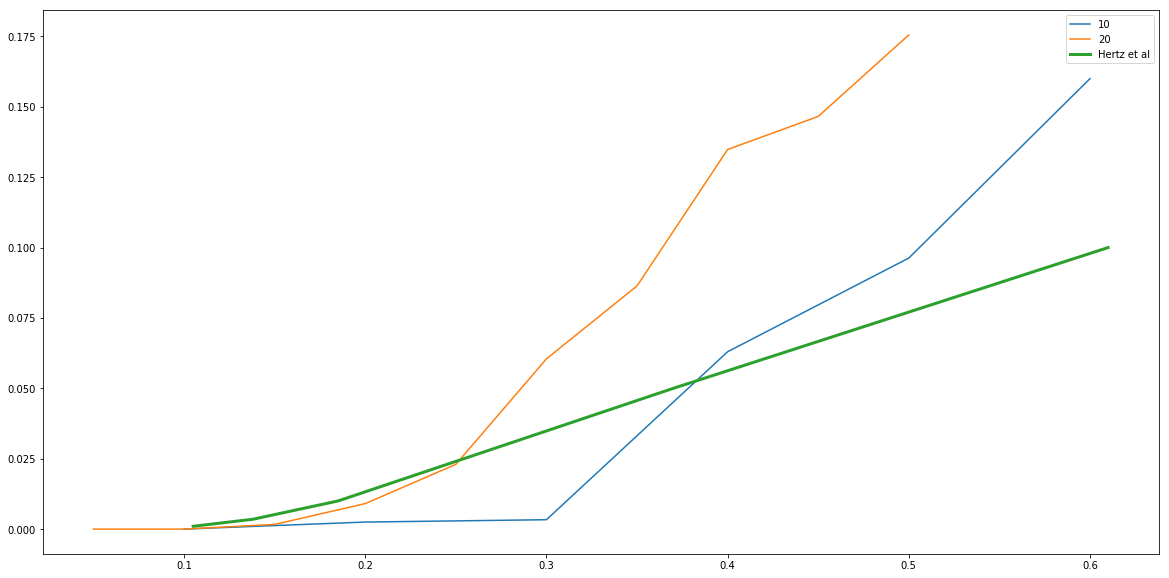

In [232]:
PlotCapacity(asyncCapacity,tableHertzEtAl)

In [233]:
def syncHopfield(seed,w,N,M):
    outVal = np.copy(seed);
    iteration = 1;
    changed = True;
    guard=500
    newVal = np.zeros(outVal.shape);
    while(changed):
        guard-=1
        changed = False;
        for i in range(len(outVal)):
            hi=signo(w[i,:].reshape(1,-1).dot(outVal))
            changed |= (hi != outVal[i])
            newVal[i]=hi
        outVal=newVal
        
        if guard == 0:
            raise ExceededMaxIterations("Exceeded iterations range: N=%i, M=%i" % [M ,N])
            
    return outVal

Capacidad de la red para Hopfield Síncrono:

In [237]:
syncCapacity=FillTable(syncHopfield, randImageGen, np.arange(10,30,10))
syncCapacity.transpose()

N        10                                               20            \
P        1    2         3         4         5        6    1    2    3    
PError  0.0  0.0  0.009167  0.070263  0.101217  0.15746  0.0  0.0  0.0   

N                                                                         
P            4         5         6      7         8         9         10  
PError  0.00875  0.020333  0.052381  0.085  0.127917  0.141852  0.180214

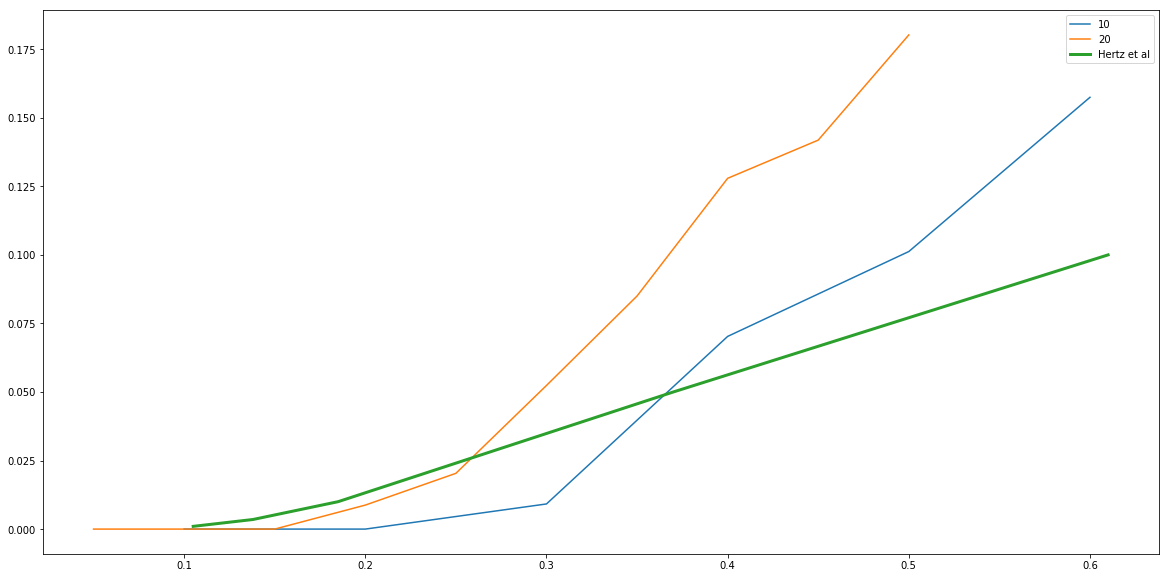

In [238]:
PlotCapacity(syncCapacity,tableHertzEtAl)

No se pudo reproducir la tabla.
Se calculó la Probabilidad de error con un intervalo de confianza del 99%
Se observa que la probabilidad de error para un dado factor Pmax/N aumenta conforme incrementa N.
Se repitió el experimento utilizando hopfield con actualización sincrónica. El procesamiento fue considerablemente mas lento pero no se observaron cambios en los resultados 

### b) Analice cómo cambia la capacidad de una red en función de la correlación entre patrones

Las imágenes se correlacionaron de la siguiente manera:

- La primer imágen (n = 1)  es pseudo aleatoria
- La n-ésima imágen con n > 1 se compone de los valores de n-1 para K < N posiciones elegidas al azar. El resto de los pasociones toma valores aleatorios.

In [269]:
def genCorrelatedImages(N,P,ro):
    Images=randImageGen(N,P)
    for n in range(1,P):
        rndIdx=np.random.choice(np.arange(20),int(np.floor(20*ro)))
        Images[n][rndIdx]=Images[n-1][rndIdx]
    return Images

In [270]:
def corrFillTable(algo, N, span ):
    df=pd.DataFrame(columns=["ro","P","PError"]).set_index(["ro","P"])

    for ro in span:
        pError=0
        P=0
        while pError < 0.15:
            P+=1
            roundRo = np.floor(N*ro)/N
            pError = repeatPError(algo,lambda n,p:genCorrelatedImages(n,p,roundRo),N,P)
            df.loc[(roundRo,P),"PError"]=pError
            #print(N,P,pError),
    return df

In [275]:
def corrPlotCapacity(df):
    for ro, new_df in df.groupby(level=0):
        ndf=new_df.reset_index()
        plt.plot(ndf["P"],ndf["PError"],label=ro)
    plt.legend()

In [277]:
corrCapacity=corrFillTable(hopfield, 30, np.arange(0,1,0.1))
corrCapacity

KeyboardInterrupt: 

In [ ]:
corrPlotCapacity(corrCapacity)

In [279]:

for ro in np.arange(0,1,0.1):
    imgs = genCorrelatedImages(30,3, ro)
    
    print(imgs)
    print(ro)
    print(numpy.corrcoef(imgs[0],imgs[1]))
        

[array([[-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]]), array([[-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.]]), array([[ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
 

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


[array([[ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.]]), array([[ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.]]), array([[-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
 